Back to the main [Index](../index.ipynb)  <a id="top"></a>

<div class="jumbotron">
  <h1 class="display-3">Phonon linewidths and Eliashberg function in metals</h1>
  <p class="lead">Aluminium</p> 
  <hr class="my-4">
  <p>
In this lesson, we discuss how to compute the phonon linewidths and the Eliashberg function in metals.
We start with a very brief discussion of the basic equations and some technical details about the Abinit implementation. Then we show how to build an AbiPy flow to automate the multiple steps required 
by these calculations.
</p>
<p>
In the second part, we use the AbiPy objects to analyze the results. We start from the simplest case of a single  calculation whose most important results are stored in the A2F.nc netcdf file. Then we show how to use the A2fRobot to handle multiple netcdf files and perform convergence studies. 
</p>
</div>

## Table of Contents
[[back to top](#top)]

* [A bit of theory](#A-bit-of-theory-and-some-details-about-the-implementation)
* [Technical details](#Technical-details)
* [Building the Flow](#Building-the-Flow)
* [Electronic properties](#Electronic-properties)
* [Vibrational properties](#Vibrational-properties)
* [Linewidths and Eliashberg function](#Phonon-linewidths-and-Eliashberg-function)
* [Convergence studies with A2FRobot](#Using-the-A2FRobot-for-convergence-studies)


## A bit of theory and some details about the implementation
[[back to top](#top)]
$\newcommand{\kk}{{\mathbf k}}$
$\newcommand{\qq}{{\mathbf q}}$
$\newcommand{\kpq}{{\kk+\qq}}$
$\newcommand{\RR}{{\mathbf R}}$
$\newcommand{\rr}{{\mathbf r}}$
$\newcommand{\<}{\langle}$
$\renewcommand{\>}{\rangle}$
$\newcommand{\KS}{{\text{KS}}}$
$\newcommand{\ww}{\omega}$
$\newcommand{\ee}{\epsilon}$
$\newcommand{\dd}{{\,\text{d}}}$


The phonon linewidths are proportional to the electron phonon coupling, and depend on the phonon wavevector $q$
and the branch index $\nu$:

\begin{equation}
    \gamma_{\qq\nu} = 2\pi \omega_{\qq\nu} \sum_{mn\kk} |g_{mn\nu}(\kk, \qq)|^2 \delta(\ee_{\kpq m}) \delta(\ee_{\kk n})
\end{equation}

Throughout these notes we shall use Hartree atomic units ($e = \hbar = m_e = 1$), the Fermi level is set to zero.

The electron-phonon matrix elements are defined by:

\begin{equation} %\label{eq:eph_matrix_elements}
    g_{mn}^{\nu}(\kk,\qq) = \dfrac{1}{\sqrt{2\omega_{\qq\nu}}} \<\psi_{m \kpq} | \Delta_{\qq\nu} V^\KS |\psi_{n\kk}\> 
\end{equation}

For further details about $\Delta_{\qq\nu} V^\KS$ and their Fourier interpolation
see the [previous lesson](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/sigeph/lesson_sigeph.ipynb)
on the EPH self-energy and [Phys. Rev. B 78, 045124](dx.doi.org/10.1103/PhysRevB.78.045124).

The Eliashberg function, $\alpha^2F(\omega)$, is similar to the density of states of the phonons, $F(\omega)$, 
but is weighted according to the coupling of the phonons to the electrons:

\begin{equation}
    \alpha^2F(\omega) = -\dfrac{1}{N_F} \sum_{\qq\nu} \dfrac{\gamma_{\qq\nu}}{\omega_{\qq\nu}} \delta(\ww - \ww_{\qq \nu})
\end{equation}

<!--
From a physical point of view, this function gives the *strenght* by which a phonon of frequency $\omega$
scatters an electronic states on the Fermi surface
For spin unpolarized systems:
-->

The first inverse moment of $\alpha^2F(\omega)$ gives the total coupling strength, 
or mass renormalization factor, $\lambda$.

\begin{equation}
    \lambda = \int \dfrac{\alpha^2F(\omega)}{\omega}\dd\omega = \sum_{\qq\nu} \lambda_{\qq\nu}
\end{equation}

\begin{equation}
    \lambda_{\qq\nu} = \dfrac{\gamma_{\qq\nu}}{\pi N_F \ww_{\qq\nu}^2}
\end{equation}

From $\lambda$, using the [McMillan formula](https://doi.org/10.1103/PhysRev.167.331) 
as modified by Allen and Dynes in [Phys. Rev. B 12 905](https://doi.org/10.1103/PhysRevB.12.905), 
one can estimate the superconducting critical temperature $T_c$ in the **isotropic** case.

\begin{equation}
    T_c = \dfrac{\omega_{log}}{1.2} \exp \Biggl [ 
        \dfrac{-1.04 (1 + \lambda)}{\lambda ( 1 - 0.62 \mu^*) - \mu^*} 
    \Biggr ]
\end{equation}

where the logarithmic moment, $\omega_{log}$, is defined by:

\begin{equation}
    \omega_{log} = \exp \Biggl [ 
    \dfrac{2}{\lambda} \int \dfrac{\alpha^2F(\omega)}{\omega}\log(\omega)\dd\omega \Biggr 
    ]
\end{equation}

The formula contains the $\mu^*$ parameter which approximates the effect of the Coulomb interaction.
It's common to treat $\mu^*$ as an *adjustable parameter* to reproduce (explain) the experimental $T_c$ 
from the ab-initio computed $\lambda$.

It is worth noting that, if we assume constant e-ph matrix elements in the BZ, the phonon linewidths 
become proportional to the so-called *nesting* function defined by:

\begin{equation}
    N(\qq) = \sum_{mn\kk} \delta(\ee_{\kpq m}) \delta(\ee_{\kk n})
\end{equation}

Roughly speaking, there are two factors entering into play in the equation for the phonon linewidths: 
the behaviour in (k, q) space of the matrix elements and the *geometrical* contribution related 
to the shape of the Fermi surface (described by the nesting term).

### Implementation details:

The input variables *optdriver = 7* and *eph_task = 1* activate the computation of:

\begin{equation}
    \gamma_{\qq\nu} = 2\pi \omega_{\qq\nu} \sum_{pp'} d_{\qq p}^* \tilde\gamma_{p p'}(\qq) d_{\qq p'}^*
\end{equation}

for all q-points in the IBZ as determined by the `ddb_ngqpt` input variable.
In the above equation, $p$ is a short-hand notation for atom index and direction, 
$\vec d$ is the phonon displacement and $\tilde\gamma_{p p'}(\qq)$ is given by:

\begin{equation}
    \tilde\gamma_{p p'}(\qq) = 
    \sum_{mn\kk} g_{mn,p}(\kk, \qq)^*  g_{mn,p'}(\kk, \qq)  \delta(\ee_{\kpq m}) \delta(\ee_{\kk n}).
\end{equation}

The $\tilde\gamma_{p p'}(\qq)$ matrix has the same symmetries as the dynamical matrix
and the elements in the *full* BZ can be obtained by *rotating* the initial set of q-points in the IBZ.

Once $\tilde\gamma(\qq)$ is known in the *full* BZ, one can Fourier transform to real space with:

\begin{equation}
    \tilde\gamma_{p p'}(\RR) = \sum_\qq e^{i\qq\cdot\RR} \tilde\gamma_{p p'}(\qq)
\end{equation}

and use Fourier interpolation to obtain $\gamma_{\qq\nu}$ everywhere in the BZ at low cost
(a similar approach is used for the dynamical matrix and phonon frequencies).
<!--
Note that we interpolate the matrices in this representation instead of the phonon mode representation
to avoid numerical instabilities introduce by band crossings.
The code computes $\tilde\gamma$ for all q-points in the IBZ, each matrix is re-symmetrized 
if symdynmat == 1 so that degeneracies at high-symmetry q-points are correctly reproduced.
-->

Thanks to the relatively inexpensive Fourier interpolation, one can obtain the phonon linewidths along 
an arbitrary q-path and evaluate the Eliashberg function on a q-mesh (specified by *ph_ngqpt*) 
that can be made **much denser** than the initial ab-initio DDB sampling (specified by *ddb_ngqpt*) and
even denser than the `eph_ngqpt_fine` q-mesh used to interpolate the DFPT potentials.

Note that the calculation of phonon linewidths in metals is made difficult 
by the slow convergence of the double-delta integral over the Fermi surface. 
It is therefore convenient to use a coarse k-mesh to calculate phonons with DFPT on a suitable q-grid
and then use a denser k-mesh to perform the integration over the Fermi surface.
The resolution in q-space can be improved by interpolating the DFPT potentials via the
`eph_ngqpt_fine` input variable as discussed in the [previous EPH lesson](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/sigeph/lesson_sigeph.ipynb).


## Suggested references
[[back to top](#top)]

The general theory of electron-phonon coupling and Eliashberg superconductivity is reviewed 
by P.B. Allen and B. Mitrovic
in [Theory of Superconducting Tc](https://www.sciencedirect.com/science/article/pii/S0081194708606657). 
The first implementations similar to that in Abinit are those in 
[Savrasov](https://doi.org/10.1103/PhysRevB.54.16487) and
[Liu](https://doi.org/10.1103/PhysRevB.53.R7575).

## Technical details

From the previous discussion, it should be clear that a typical calculation of phonon linewidths requires:

1. An initial set of KS wavefunctions and eigenvalues.
2. The knowledge of the dynamical matrix $D(\qq)$ from which one 
   can obtain frequencies and displacements everywhere in the BZ via Fourier interpolation.
3. A set of DFPT potentials given in the IBZ

Thanks to these three ingredients, the code can compute the EPH matrix elements
and perform the integration over the Fermi surface.
A schematic representation of a typical workflow with Abinit is given in the figure below:

<img src="https://raw.githubusercontent.com/abinit/abipy_assets/master/eph_workflow.png" width="600" height="600">

The `mrgddb` and `mrgdv` are Fortran executables whose main goal is to produce the final files
required in the EPH code.

Note, in particular, how the computation of the WFK file and the DFPT part of the graph are now decoupled.
This is the approach we are going to implement with AbiPy to converge the phonon linewidths in Al:

1. Compute DFPT phonons on a 4x4x4 q-mesh with a coarse 8x8x8 k-sampling

2. Generate 3 WFK files on a much denser k-mesh (x16, x24, x32) 

3. Run the EPH code with

  - one of the WFK files generated in point 2.
  - interpolated DFPT potentials (from the initial 4x4x4 to a 8x8x8 q-mesh)

4. Compute the Eliashberg function on the `ph_ngqpt` mesh via Fourier interpolation. 
5. Analyze the convergence of the results wrt `nkpt`. 

## Building the Flow
[[back to top](#top)]

Before starting, we need to import the python modules used in this notebook:

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np
import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook
import abipy.flowtk as flowtk

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

and a function from the `lesson_eph_al` module to build our AbiPy flow.

In [2]:
from lesson_eph_al import build_flow

<div class="alert alert-info" role="alert">
Please read the code carefully, in particular the comments.
Don't worry if the meaning of some input variables is not immediately clear
as we will try to clarify the most technical parts in the rest of this notebook.
</div>

In [3]:
abilab.print_source(build_flow)

OK the function is a little bit long but it's normal as we are computing
in a single workflow the *electronic* properties, the *vibrational* spectrum 
and the *phonon linewidths* with different k-point samplings.

Note that we have already encountered similar flows in the previous AbiPy lessons. 
The calculation of electronic band structures is
discussed in 
[lesson_base3](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/base3/lesson_base3.ipynb)
while an example of `Flow` for phonon calculations is given in 
[lesson_dfpt](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/dfpt/lesson_dfpt.ipynb).

The novelty is represented by the generation of the `EphTasks` 
in which we have to specify several variables related to phonons and the EPH self-energy.
For your convenience, we have grouped the variables used in the `EphTask` in sub-groups:

<img src="https://github.com/abinit/abipy_assets/blob/master/eph_variables.png?raw=true">

Hopefully things will become clearer if we build the flow and start to play with it:

In [4]:
flow = build_flow(options=None)
flow.show_info()

<Flow, node_id=312681, workdir=flow_eph_al>
Number of works: 3, total number of tasks: 22
Number of tasks with a given class:

Task Class      Number
------------  --------
ScfTask              1
NscfTask             4
PhononTask          14
EphTask              3

We then print the input of the last `EphTask`. 
Please read carefully the documentation of the variables, in particular 
those in the `dfpt` and `eph` sections.

In a nutshell: we read a WKF on a 32x32x32 k-mesh and a DDB on a 4x4x4 q-mesh,
activate the computation of phonon linewidths with `optdriver` and `eph_task`,
interpolate the potentials onto a 8x8x8 q-mesh with `eph_ngqpt_fine` and set other variables 
for the computation of the phonon linewidths around the Fermi surface.

In [5]:
print(flow[-1][-1])
flow[-1][-1].input

<EphTask, node_id=312715, workdir=flow_eph_al/w2/t2>


<AbinitInput at 4727763800>

<div class="alert alert-info" role="alert">
The input does not contain any `irdwfk` or `getwfk` variable. AbiPy will add the required `ird*` 
variables at runtime and create symbolic links to connect this task to its parents.
</div>

As usual, it's much easier to understand what's happening if we plot a graph
with the individual tasks and their connections.
Since there are several nodes in our graph, we mainly focus on the EPH part.

Let's have a look at the parents of the last `EphTask` with:

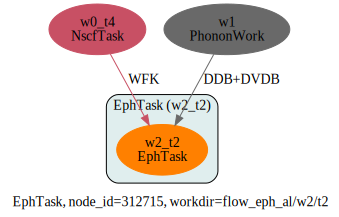

In [6]:
flow[-1][-1].get_graphviz()

We don't repeat here the detailed description of the Flow because it is very similar in spirit
to what has been already done in the [previous EPH lesson](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/sigeph/lesson_sigeph.ipynb).
Hopefully, you are already familiar with the AbiPy philosophy.


In [7]:
print("ngkpt in EPH tasks:", [task.input["ngkpt"] for task in flow[2]])

ngkpt in EPH tasks: [[16, 16, 16], [24, 24, 24], [32, 32, 32]]


In [8]:
flow[2].get_vars_dataframe("ngkpt")

,ngkpt
w2_t0,"[16, 16, 16]"
w2_t1,"[24, 24, 24]"
w2_t2,"[32, 32, 32]"


For completeness, we show the entire flow with the different connections:

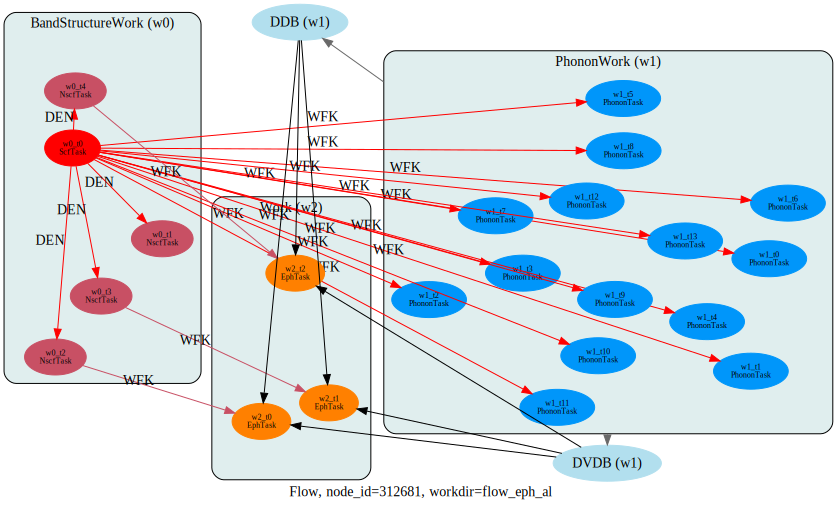

In [9]:
flow.get_graphviz()

<div class="alert alert-info" role="alert">
You may wonder why we have so many tasks especially if you are used to the multi-dataset philosophy of Abinit.
Indeed if you are a `ndtset` master, it should not be so difficult for you
to write a *single input file* that performs the same kind of converge study.
Still you have to consider that the multi-dataset approach does not scale well: 
this kind of calculation has several independent steps 
that could be executed in parallel whereas abinit datasets are executed sequentially. 
This makes a huge difference when running on clusters with hundreds or thousands of CPUs because 
the *time to solution* can be considerably reduced with this kind of parallelism.
</div>

<!-- Note that the q-mesh for the self-energy is denser than the *ab-initio* one used for the DFPT run.
This means that the code will activate the Fourier interpolation of the DFPT potentials.
Note that the k-mesh and the q-mesh cannot be arbitrary. 

<div class="alert alert-info" role="alert">
Remember that the $k$-point mesh cannot be chosen arbitrarily
since all $k$ wavevectors should connect two $k$ points of the grid used for the electrons.

More specifically, the q-mesh associated to the 
`DDB` (`DVDB`) must be a submesh of the k-mesh for electrons.
Moreover the EPH code can compute self-energy corrections only for the states that are available in the `WFK` file.
</div>
-->

Now we can generate the directories and the input files of the `Flow` with:

    flow.build_and_pickle_dump()

and then use the `abirun.py` script to launch the entire calculation:

    abirun.py flow_eph_al scheduler
    
You may want to run this example in the terminal if you've already installed and configured AbiPy and Abinit
on your machine.
If you prefer to skip this part, jump to next section in which we focus on the post-processing of the results.
Note that the output files are already available in the [github repository](https://github.com/abinit/abitutorials)
so it's possible to try the AbiPy post-processing tools without having to run the flow.
In particular, one can use the command line and the commands:

    abiopen.py FILE
    
to open the file inside ipython,

    abiview a2f out_A2F.nc
    
to visualize the EPH results and finally,

    abicomp a2f flow_ep_al/
    
 to compare multiple `A2F.nc` files with the robot and ipython.

## Electronic properties
[[back to top](#top)]

Let's focus on the electronic properties first.

In [60]:
!find flow_eph_al/ -name "out_GSR.nc"

flow_eph_al//w0/t0/outdata/out_GSR.nc
flow_eph_al//w0/t1/outdata/out_GSR.nc
flow_eph_al//w0/t2/outdata/out_GSR.nc
flow_eph_al//w0/t3/outdata/out_GSR.nc
flow_eph_al//w0/t4/outdata/out_GSR.nc


The task `w0/t0` computed the electronic band structure on a high-symmetry k-path.
Let's plot the bands with:

<IPython.core.display.Javascript object>


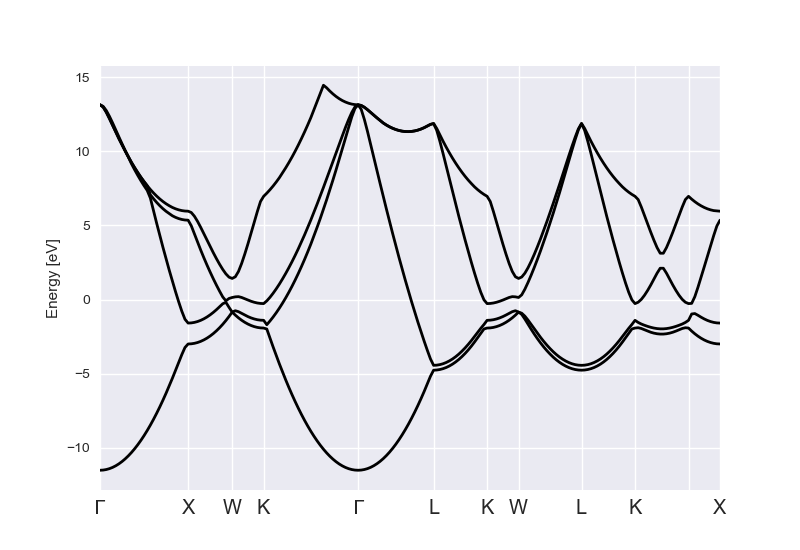

In [61]:
with abilab.abiopen("flow_eph_al/w0/t1/outdata/out_GSR.nc") as gsr:
    ebands_kpath = gsr.ebands
    
# NB: Fermi level set to zero
ebands_kpath.plot();

In [62]:
#print(ebands_kpath)

To better understand what’s happening at $\ee_F$, we can plot the bandwidths with:

<IPython.core.display.Javascript object>


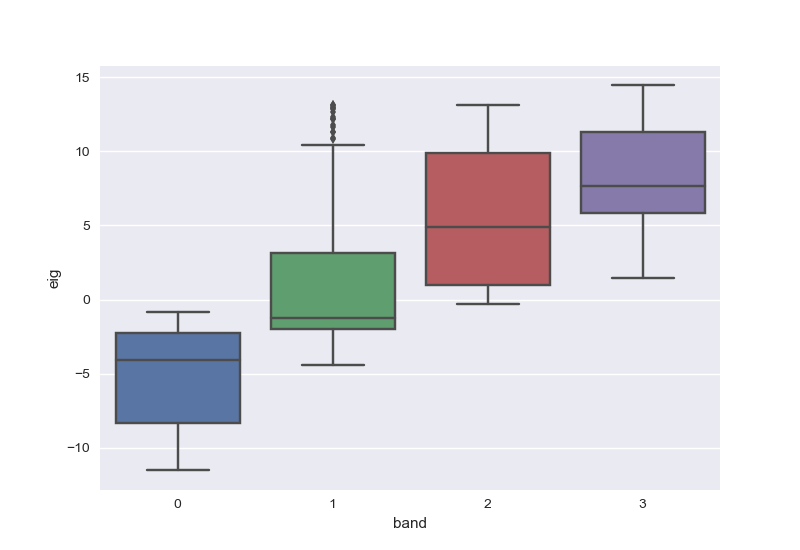

In [63]:
ebands_kpath.boxplot();

There's only one band **index** crossing the Fermi level if we exclude a tiny portion with band index 2 (see the region close to the W point).
As phonon lifetimes are very sensitive to the Fermi surface sampling, 
it's a good idea to analyze the convergence of the electronic DOS, 
in particular the behavior in the region around $\ee_F$.

Let's use the `GsrRobot` to load all the `GSR` files produced by the `w0` work:

In [64]:
gsr_robot = abilab.GsrRobot.from_dir_glob("flow_eph_al/w0/t*/")
gsr_robot

Label                                 Relpath
------------------------------------  ------------------------------------
flow_eph_al/w0/t0/outdata/out_GSR.nc  flow_eph_al/w0/t0/outdata/out_GSR.nc
flow_eph_al/w0/t1/outdata/out_GSR.nc  flow_eph_al/w0/t1/outdata/out_GSR.nc
flow_eph_al/w0/t2/outdata/out_GSR.nc  flow_eph_al/w0/t2/outdata/out_GSR.nc
flow_eph_al/w0/t3/outdata/out_GSR.nc  flow_eph_al/w0/t3/outdata/out_GSR.nc
flow_eph_al/w0/t4/outdata/out_GSR.nc  flow_eph_al/w0/t4/outdata/out_GSR.nc

In total, we have 5 `GSR` files but `w0/t1` computed the energies along the k-path and the 
DOS **requires** a homogeneous sampling.
Let's remove this file from the robot with:

In [65]:
gsr_robot.pop_label("flow_eph_al/w0/t1/outdata/out_GSR.nc")
gsr_robot

Label                                 Relpath
------------------------------------  ------------------------------------
flow_eph_al/w0/t0/outdata/out_GSR.nc  flow_eph_al/w0/t0/outdata/out_GSR.nc
flow_eph_al/w0/t2/outdata/out_GSR.nc  flow_eph_al/w0/t2/outdata/out_GSR.nc
flow_eph_al/w0/t3/outdata/out_GSR.nc  flow_eph_al/w0/t3/outdata/out_GSR.nc
flow_eph_al/w0/t4/outdata/out_GSR.nc  flow_eph_al/w0/t4/outdata/out_GSR.nc

and use a small lambda function to change the labels associated to the files 
so that we have the number of k-points in the IBZ:

In [66]:
gsr_robot.remap_labels(lambda gsr: "nkpt: %d" % gsr.nkpt)

OrderedDict([('nkpt: 29', 'flow_eph_al/w0/t0/outdata/out_GSR.nc'),
             ('nkpt: 145', 'flow_eph_al/w0/t2/outdata/out_GSR.nc'),
             ('nkpt: 413', 'flow_eph_al/w0/t3/outdata/out_GSR.nc'),
             ('nkpt: 897', 'flow_eph_al/w0/t4/outdata/out_GSR.nc')])

Now we can finally compare the electronic DOS obtained with the different k-meshes:

<IPython.core.display.Javascript object>


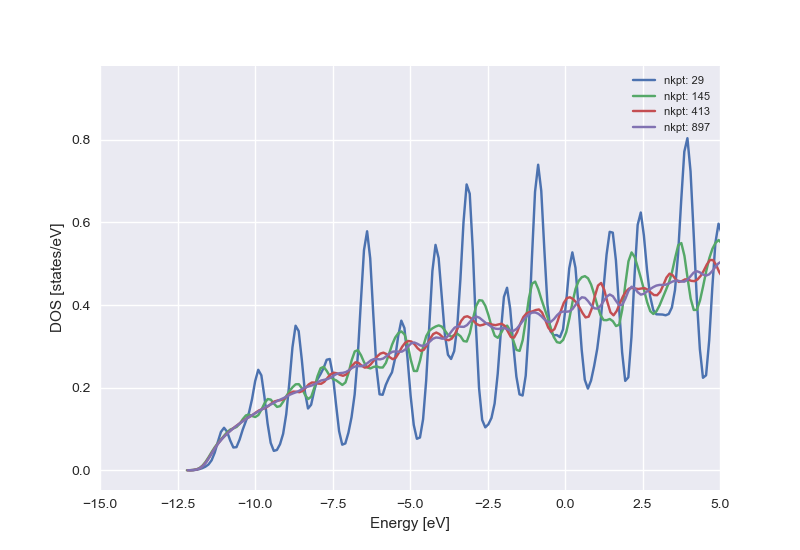

In [67]:
gsr_robot.combiplot_edos(xlims=[-15, +5]);

Clearly, the 8x8x8 k-mesh used to compute the density is not enough to converge the DOS at $\ee_F$.
Remember, however, that we have decided to use a minimalistic sampling in the GS/DFPT run 
to keep the calculation manageable.
In real life, one should use a much denser k-sampling for the GS/DFPT and this is particularly 
true if we are trying to relax the structure.
Let's forget about this technical point and focus on the DOS obtained with the other two k-meshes.

As you can see, even if 145 k-points in the IBZ are not enough, the DOS is becoming *smoother*
and starts to resemble the one of the free-electron gas (as a matter of fact the band dispersion of Al is not
that different from the ideal free-electron model provided that BZ folding is taken into account).

Visual inspection suggests that the k-sampling becomes *acceptable* beyond 24x24x24 (413 nkpt).

<div class="alert alert-info" role="alert">
The convergence of the DOS at the Fermi level does not necessarly imply convergence in the final EPH results. 
This is something that should be checked expliclty by looking at the behaviour of the final observables
as a function of the input parameters.
</div>

In the introduction, we mentioned that there are two factors governing the strengh of the E-PH coupling in metals:
the behaviour in (k, q)-space of the matrix elements and the *geometrical* contribution due to the Fermi surface.

\begin{equation}
    N(\qq) = \sum_{mn\kk} \delta(\ee_{\kpq m}) \delta(\ee_{\kk n})
\end{equation}

To understand the *geometrical* contribution, it is useful to visualize the Fermi surface.
Unfortunately, graphical applications usually require KS eigenvalues on a 
$\Gamma-$centered k-mesh in the *full* BZ whereas ab-initio codes usually work with KS states 
in the *irreducible* wedge.

Fortunately, we can use AbiPy to reconstruct the KS eigenvalues in the full BZ:

In [68]:
# Select the last GSR file in thr robot.
eb3d = gsr_robot.abifiles[-1].ebands.get_ebands3d()

and then use matplotlib to visualize the Fermi energy isosurfaces:

<IPython.core.display.Javascript object>


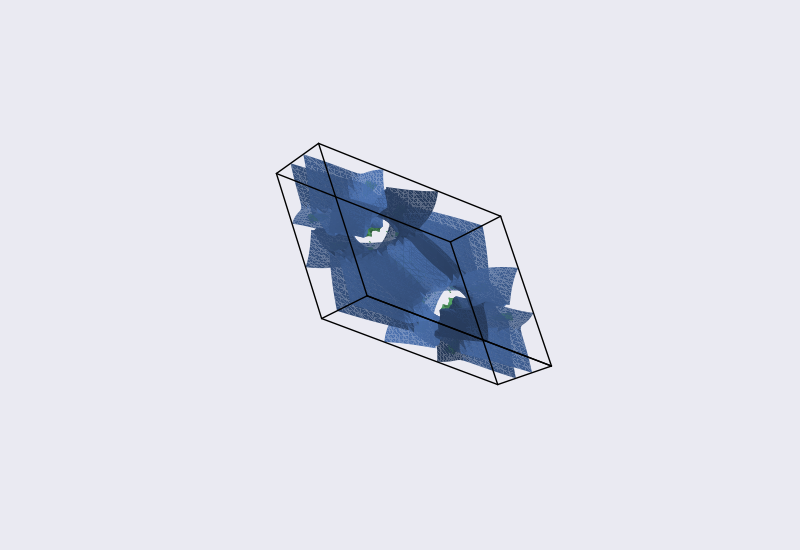

In [69]:
eb3d.plot_isosurfaces();

Note that, at present, the matplotlib version is only able to display isosurfaces 
in the unit cell of the reciprocal lattice.
To visualize isosurfaces in the first BZ, one can export the data 
into BXSF format and then call [xcrysden](http://www.xcrysden.org/) with:

In [70]:
#eb3d.xcrysden_view()

This is the image you should get with xcrysden: 

<img src="https://github.com/abinit/abipy_assets/blob/master/alfs_xcrysden.png?raw=true" width="600" height="600"/>

## Vibrational properties
[[back to top](#top)]

Now we turn our attention to the vibrational properties.
AbiPy has already merged all the independent atomic perturbations in `flow_eph_al/w1/outdata/out_DDB`:

In [71]:
!find flow_eph_al/ -name "out_DDB"

flow_eph_al//w0/t0/outdata/out_DDB
flow_eph_al//w1/outdata/out_DDB


In [72]:
!cat flow_eph_al/w1/outdata/mrgddb.stdin

/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/outdata/out_DDB
DDB file merged by PhononWork on Mon Mar 12 12:35:56 2018
14
/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/t0/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/t1/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/t2/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/t3/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/t4/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/t5/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/t6/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/t7/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/t8/outdata/out_DDB
/Users/gmatteo/git_rep

In the same directory, we have the `DVDB` file containing the independent DFPT potentials

In [73]:
!find flow_eph_al/ -name "out_DVDB"

flow_eph_al//w1/outdata/out_DVDB


In [74]:
#!cat flow_eph_al//w1/outdata/mrgdvdb.stdin

Let's open the `DDB` file computed on the 4x4x4 q-mesh with:

In [75]:
ddb = abilab.abiopen("flow_eph_al/w1/outdata/out_DDB")
print(ddb)

================================= File Info =================================
Name: out_DDB
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w1/outdata
Size: 42.10 kb
Access Time: Mon Mar 12 12:47:17 2018
Modification Time: Mon Mar 12 12:35:56 2018
Change Time: Mon Mar 12 12:35:56 2018

================================= Structure =================================
Full Formula (Al1)
Reduced Formula: Al
abc   :   2.806386   2.806386   2.806386
angles:  60.000000  60.000000  60.000000
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Al      0    0    0

Abinit Spacegroup: spgid: 0, num_spatial_symmetries: 48, has_timerev: True, symmorphic: False

================================== DDB Info ==================================

Number of q-points in DDB: 8
guessed_ngqpt: [4 4 4] (guess for the q-mesh divisions made by AbiPy)
Has electric-field perturbation: False
Has Born effective charges: True


and then invoke `anaddb` to compute phonon bands and DOS:

In [76]:
phbst, phdos = ddb.anaget_phbst_and_phdos_files()

Finally we plot the results with:

<IPython.core.display.Javascript object>


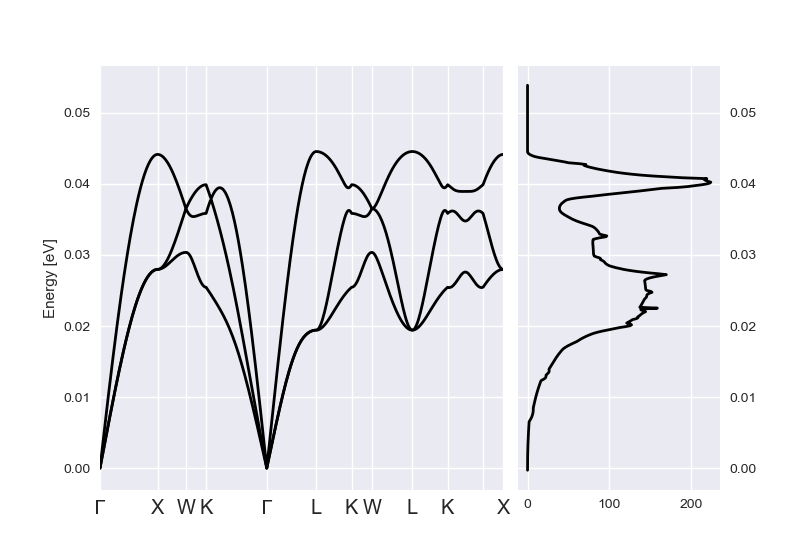

In [77]:
phbst.phbands.plot_with_phdos(phdos);

The vibrational spectrum seems OK but remember that we are *enforcing* the acoustic sum rule
with `asr`.
Since our input parameters are underconverged, it's a good idea to compare the spectrum with/without `asr`:

In [78]:
ph_plotter = ddb.anacompare_asr()

<IPython.core.display.Javascript object>


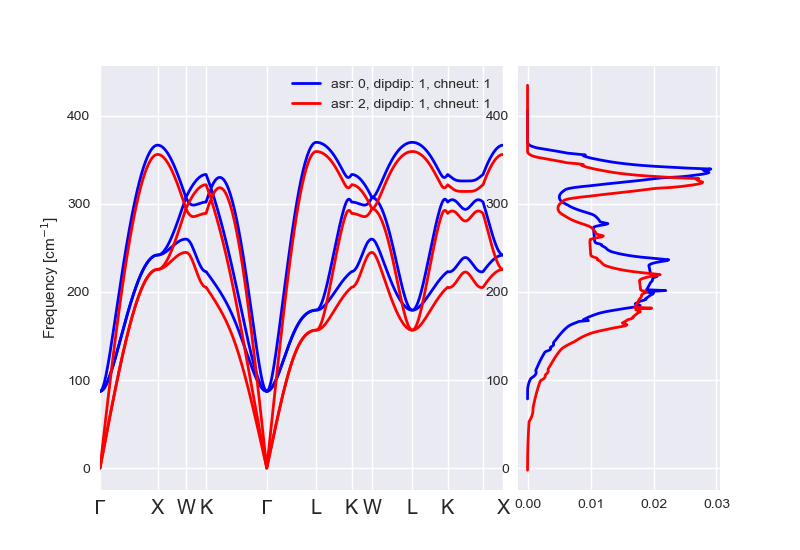

In [79]:
ph_plotter.combiplot(units="cm-1");

<div class="alert alert-warning" role="alert">
Not so good! The breaking of the ASR is quite large.
This is mainly due to the use of a too small value for `ecut`.
In real life, we should increase `ecut` and rerun the DFPT part but since this is a tutorial
aiming at showing how to perform EPH calculations, we ignore this convergence issue 
keeping in mind that we should redo all our calculations with larger ecut before submitting the final
version of the paper!
</div>

We can now finally turn our attention to the phonon linewidths and the Eliashberg function. 

## Phonon linewidths and Eliashberg function
[[back to top](#top)]

We have generated a pair of `DDB`-`DVDB` files on a 4x4x4 q-mesh
and **three** `WFK` files with a much denser k-sampling (x16, x24, x32).
In total we have three EPH calculations done with different k-meshes to analyze.

Let's focus on the output files produced with the 16x16x16 k-mesh by the first `EphTask` in `w2/t0`:

In [80]:
!ls flow_eph_al/w2/t0/outdata

out_A2F.nc               out_NOINTP_A2FW          out_PHDOS.nc
out_A2FW                 out_NOINTP_PH_A2FW       out_PHDOS_by_atom
out_A2FW_QPTOPT3_A2FW    out_OUT.nc               out_PHDOS_msqd
out_A2FW_QPTOPT3_PH_A2FW out_PHBANDS.agr          out_PHGAMMA
out_EBANDS.agr           out_PHBST.nc             out_PH_A2FW
out_EDOS                 out_PHDOS                out_THERMO


The most important results are stored in:
    
* *out_A2F.nc*: main results in netcdf format
* *out_PHDOS.nc*: phonon DOS and projections over atoms and directions
* *out_PBSTS.nc*: phonon band structure along the q-path

<div class="alert alert-info" role="alert">
There's also a bunch of text files with the same results in text format if you are a gnuplot/xmgrace aficionado...
</div>

Let's get a quick summary of the most important results with:

In [81]:
a2fnc = abilab.abiopen("flow_eph_al/w2/t0/outdata/out_A2F.nc")
print(a2fnc)

================================= File Info =================================
Name: out_A2F.nc
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w2/t0/outdata
Size: 254.68 kb
Access Time: Mon Mar 12 12:47:37 2018
Modification Time: Mon Mar 12 12:37:13 2018
Change Time: Mon Mar 12 12:37:13 2018

================================= Structure =================================
Full Formula (Al1)
Reduced Formula: Al
abc   :   2.806386   2.806386   2.806386
angles:  60.000000  60.000000  60.000000
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Al      0    0    0

Abinit Spacegroup: spgid: 0, num_spatial_symmetries: 48, has_timerev: True, symmorphic: False

============================== Electronic Bands ==============================
Number of electrons: 3.0, Fermi level: 7.166 [eV]
nsppol: 1, nkpt: 145, mband: 4, nspinor: 1, nspden: 1
smearing scheme: gaussian, tsmear_eV: 1.088, occopt: 7

================================ Phonon Bands ========

In the `E-PH calculation` we have the value of $\lambda$ and $\omega_{log}$ computed
with a 16x16x16 k-mesh for electrons and two q-meshes.
...

The value of $\lambda$ is smaller (almost a factor 2) with respect to other values
reported in the literature, likely due to the coarse 12x12x12 k-sampling
We'll investigate this problem in the next section.
For the time being, we prefer to focus on the visualization of the results with AbiPy.

Let's use matplotlib to plot the Eliashberg function obtained with the two q-meshes:

<IPython.core.display.Javascript object>


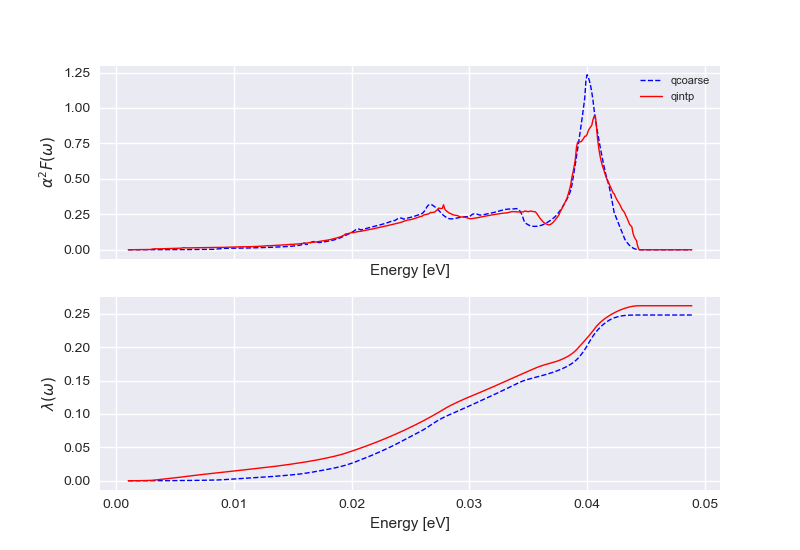

In [82]:
a2fnc.plot_a2f_interpol();

This Eliashberg function obtained on the [24, 24, 24] q-mesh looks nicer, in particular 
we see the appearance of Van-Hove singularities.
As expected, the integral $\lambda(\omega)$ is less sensitive to the interpolation in q-space.
We conclude that the fact that our $\lambda$ is too small when compared with other ab-initio calculations
is not related to the q-sampling but to the *quality* of our phonon linewidths that in turn is related 
to the description of the FS.

We can also visualize the phonon linewidths with a scatter plot: 

<IPython.core.display.Javascript object>


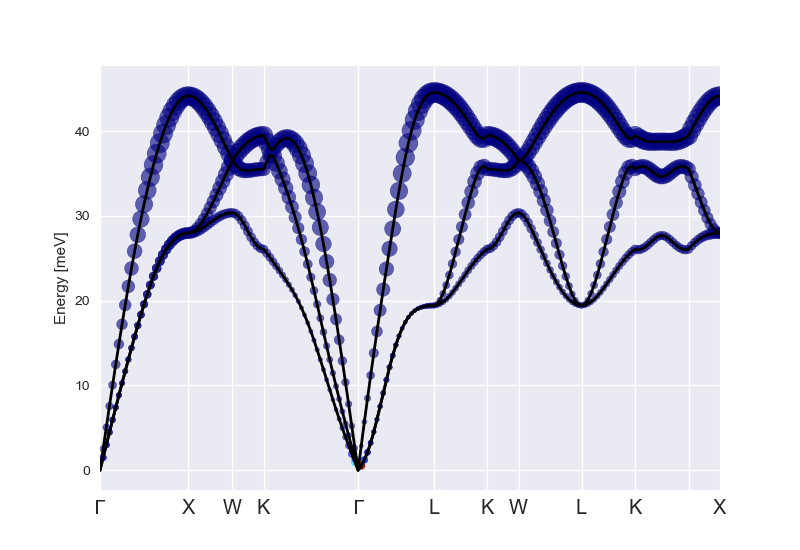

In [83]:
a2fnc.plot(units="meV", what="gamma");

In [84]:
#a2fnc.plot_with_a2f(units="meV", what="lambda");

To plot the band energies used in the calculation

In [85]:
#a2fnc.plot_ebands();

To plot the phonon frequencies, the linewidths $\gamma_{{\bf q}, \nu}$ 
and $\lambda_{{\bf q}, \nu}$ on the same figure, use:

<IPython.core.display.Javascript object>


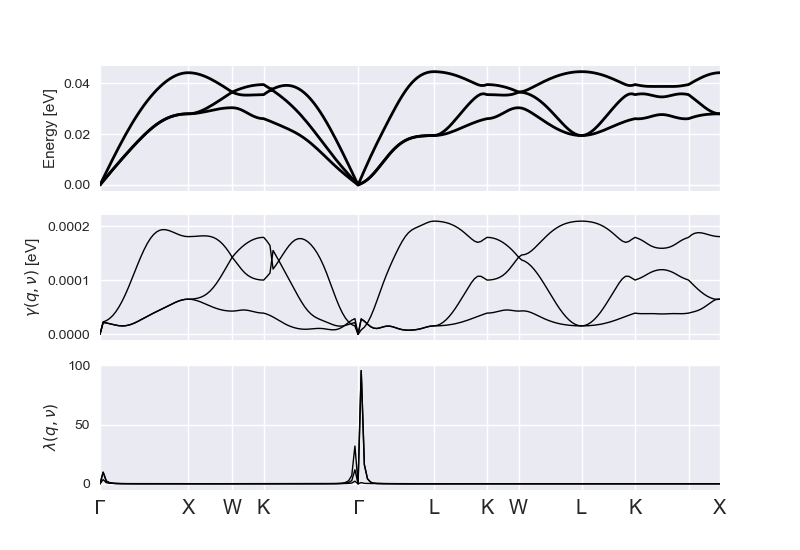

In [86]:
a2fnc.plot_eph_strength();

In principle, the linewidth of the acoustic modes should go to zero for $q \rightarrow 0$.

In [87]:
#a2fnc.a2f_qcoarse.plot();

The notation $\alpha^2 F(\omega)$ was introduced because the Eliashberg function 
is usually proportional to the phonon DOS $F(\omega)$.
There are, however, exceptions so it is useful to plot $\alpha^2F(\omega)$, $F(\omega)$ and their ratio $\alpha^2$.

It's just a matter of passing the phonon DOS computed from the `DDB` file in the previous section 
to the `plot_a2` method:

<IPython.core.display.Javascript object>


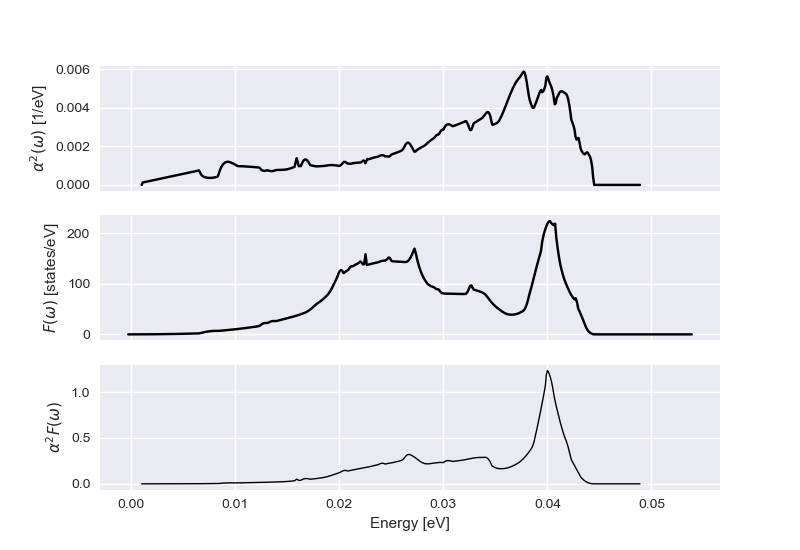

In [88]:
a2fnc.a2f_qcoarse.plot_a2(phdos=phdos);

In [89]:
#a2fnc.a2f_qintp.get_mcmillan_tc(mustar=0.1)

In [90]:
#a2fnc.a2f_qcoarse.plot_tc_vs_mustar();

To conclude this section: our results for $\lambda$ and $\alpha^2F(\omega)$ look reasonable 
but we are still far from the results reported in previous works.
Perhaps we are not completely converged and we should analyze in more detail 
what happens if we increase the k-point sampling.
Fortunately we have already computed these results in our Flow so it's just a matter of using
AbiPy to compare multiple calculations.

## Using the A2FRobot for convergence studies
[[back to top](#top)]


In this section, we use the `A2fRobot` to analyze the convergence behaviour of our results
with respect to the k-point sampling in the double-delta integral.

Let's ask our robot to open all the `A2F` files  located within the `flow_eph_al/` directory.

In [91]:
robot = abilab.A2fRobot.from_dir("flow_eph_al/")
robot

Label                     Relpath
------------------------  ------------------------------------
w2/t0/outdata/out_A2F.nc  flow_eph_al/w2/t0/outdata/out_A2F.nc
w2/t1/outdata/out_A2F.nc  flow_eph_al/w2/t1/outdata/out_A2F.nc
w2/t2/outdata/out_A2F.nc  flow_eph_al/w2/t2/outdata/out_A2F.nc

We know that all these calculations have been done with different values of `nkpt`.
Let's change the labels of the files by replacing file paths with more informative strings:

In [92]:
robot.remap_labels(lambda ncfile: "nkpt: %d" % ncfile.nkpt)

OrderedDict([('nkpt: 145', 'w2/t0/outdata/out_A2F.nc'),
             ('nkpt: 413', 'w2/t1/outdata/out_A2F.nc'),
             ('nkpt: 897', 'w2/t2/outdata/out_A2F.nc')])

and print a pandas `DataFrame` with the parameters of the calculation can help to understand the data:

In [93]:
robot.get_params_dataframe()

,nsppol,nspinor,nspden,nband,nkpt,ddb_nqbz,eph_nqbz_fine,ph_nqbz,eph_intmeth,eph_fsewin,eph_fsmear,eph_extrael,eph_fermie
nkpt: 145,1,1,1,4,145,64,512,13824,2,0.029399,0.01,0.0,0.0
nkpt: 413,1,1,1,4,413,64,512,13824,2,0.029399,0.01,0.0,0.0
nkpt: 897,1,1,1,4,897,64,512,13824,2,0.029399,0.01,0.0,0.0


As usual, it's much easier to analyze the convergence of scalar quantities.
Since we are mainly interested in $T_c$-related properties, it makes sense 
to print a table with the value of $\lambda$ and $\omega_{log}$ extracted from the different calculations:

In [94]:
robot.get_dataframe(with_params=False)

,lambda_qcoarse,omegalog_qcoarse,lambda_qintp,omegalog_qintp
nkpt: 145,0.248242,0.029566,0.262111,0.027082
nkpt: 413,0.373353,0.029148,0.401513,0.025940
nkpt: 897,0.386603,0.028770,0.417210,0.025479


This table gives the values integrated on the `eph_ngqpt` mesh as well as the values obtained
by Fourier interpolating the results on the `ph_ngqpt` mesh.
Note the **big jump** in $\lambda$ when we go from the 18x18x18 k-mesh to the 36x36x36 (~0.2 --> ~0.4).
This cleary show that our initial estimate for $\lambda$ obtained with a 18x18x18 k-mesh was really bad!
(Did I tell you that these calculations are very sensitive to the k-point sampling?)

If you prefer figures instead of tables with numbers, just use:

<IPython.core.display.Javascript object>


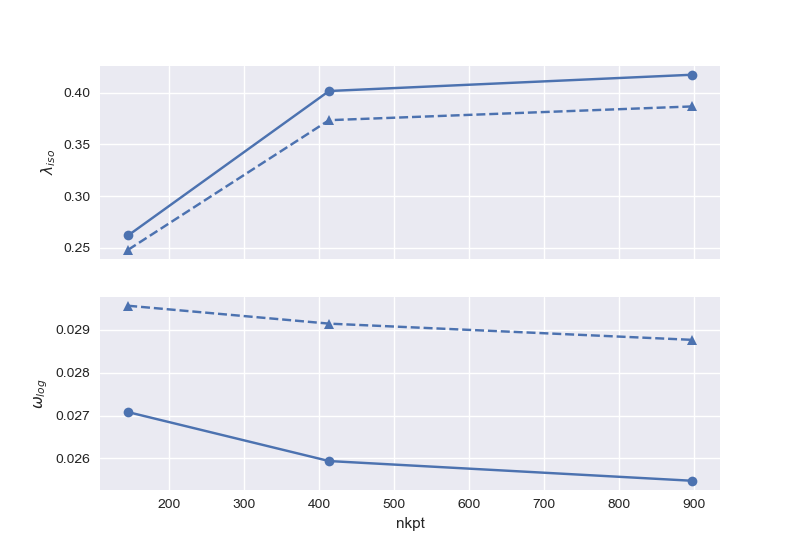

In [95]:
robot.plot_a2fdata_convergence(sortby="nkpt"); #, hue="eph_fsmear");

When converging with respect to the number of k-points, it's common to plot the
physical results as function of $\frac{1}{N_{kpt}}$.
Let's define a small function that tells our robot how to sort the results:

<IPython.core.display.Javascript object>


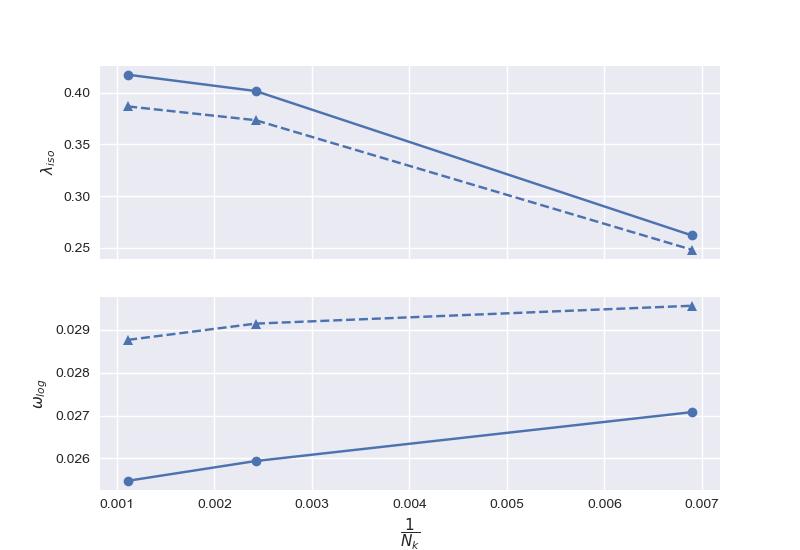

In [96]:
def inv_nkpt(a2f_file):
    """$\dfrac{1}{N_k}$"""
    return 1/ a2f_file.nkpt
    
robot.plot_a2fdata_convergence(sortby=inv_nkpt); #, hue="eph_fsmear");

At this point, our estimate for $\lambda$ should be somewhere in [0.39, 0.42] 
that compares much better with the value of 0.44 reported by Savrasov.
__Most importantly__, our results started to convergence (although slowly).
Now we know that a serious calculation of the phonon linewidhts of Al
would require something around 32x32x32 k-points (this is indeed the mesh used by Savrasov in their paper).

In [97]:
#print(robot.abifiles[-1])

In [98]:
#robot.abifiles[-1].a2f_qintp.get_mcmillan_tc(0.12)

So far, we have been focusing on $\lambda$ but what about the convergence of $\alpha^2F(\omega)$?

<IPython.core.display.Javascript object>


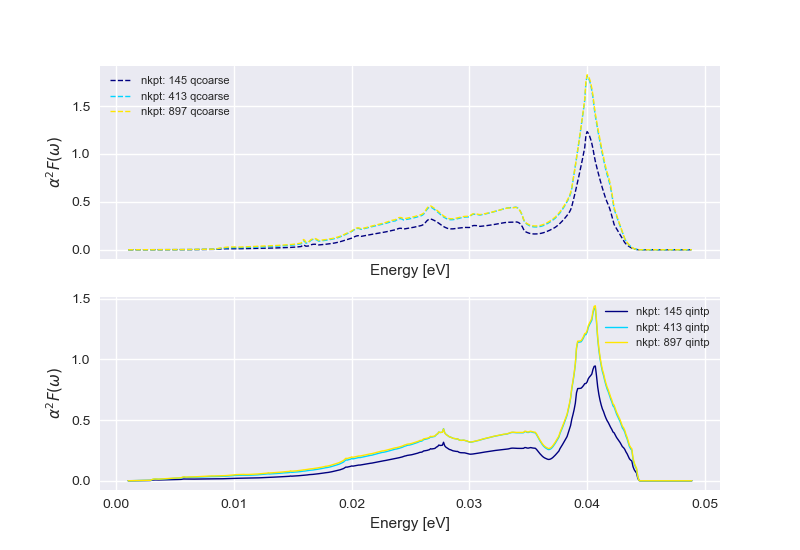

In [99]:
robot.plot_a2f_convergence();

In [100]:
print(robot.abifiles[-1])

================================= File Info =================================
Name: out_A2F.nc
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/eph_al/flow_eph_al/w2/t2/outdata
Size: 331.68 kb
Access Time: Mon Mar 12 12:47:55 2018
Modification Time: Mon Mar 12 12:45:10 2018
Change Time: Mon Mar 12 12:45:10 2018

================================= Structure =================================
Full Formula (Al1)
Reduced Formula: Al
abc   :   2.806386   2.806386   2.806386
angles:  60.000000  60.000000  60.000000
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Al      0    0    0

Abinit Spacegroup: spgid: 0, num_spatial_symmetries: 48, has_timerev: True, symmorphic: False

============================== Electronic Bands ==============================
Number of electrons: 3.0, Fermi level: 7.166 [eV]
nsppol: 1, nkpt: 897, mband: 4, nspinor: 1, nspden: 1
smearing scheme: gaussian, tsmear_eV: 1.088, occopt: 7

================================ Phonon Bands ========

In [101]:
#robot.gridplot_a2f(tight_layout=True);

In [102]:
#robot.plot_a2f_convergence(sortby="nkpt", hue="eph_fsmear", tight_layout=True);

In [103]:
#robot.plot_lambda_convergence(what="gamma", sortby="nkpt", hue="eph_fsmear", tight_layout=True);

In [104]:
#robot.abifiles[-1].plot_a2f_interpol();

In [105]:
#robot.abifiles[-1].a2f_qcoarse.plot_tc_vs_mustar(start=0.1, stop=0.2);

In [106]:
#robot.gridplot_phbands_with_a2f(units="meV");

In [107]:
#robot.plot_a2fdata_convergence(sortby="nkpt", hue=None);

## Exercises

    
* Converge the $GW$ gap of ZnO, then include the EPH self-energy.

Back to the main [Index](../index.ipynb)